# Forecasting

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
from functools import reduce
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.graphics.tsaplots as stats
from statsmodels.tsa.stattools import adfuller

## Data wrangling

### Trends dataset

In [2]:
#Importing dfs with trends data
df1 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/barcelona.csv")
df2 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/city_trip_barcelona.csv")
df3 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/flight_barcelona.csv")
df4 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/holiday_barcelona.csv")
df5 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/hotel_barcelona.csv")
df6 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/tourist_info_barcelona.csv")
df7 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/train_barcelona.csv")
df8 = pd.read_csv("../forecasting-tourism-trends/Data/Trends/visit_barcelona.csv")

# Mergind the different df into df_trends
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
df_trends = reduce(lambda left,right: pd.merge(left,right,on='Mes'), dfs)

df_trends.columns = ["period", "barcelona", "city_trip_barcelona", "flight_barcelona", 
                     "holiday_barcelona", "hotel_barcelona", "tourist_info_barcelona", 
                     "train_barcelona", "visit_barcelona"]

#Chaging period type to datetime format
df_trends["period"] = pd.to_datetime(df_trends["period"], format="%Y-%m")
df_trends = df_trends.sort_values(by="period", ascending=False).reset_index(drop=True)

#Delete the first observation of the df_trends as it does not appear in the hotel data
df_trends = df_trends.iloc[1:].copy()
df_trends.head(3)

,period,barcelona,city_trip_barcelona,flight_barcelona,holiday_barcelona,hotel_barcelona,tourist_info_barcelona,train_barcelona,visit_barcelona
1,2020-11-01,36,6,10,10,13,0,7,7
2,2020-10-01,58,0,11,12,16,0,7,9
3,2020-09-01,50,0,15,10,15,0,20,17


### Visitors data and final dataset

In [3]:
#Importing hotel visitors dataset
df = pd.read_csv("../forecasting-tourism-trends/Data/2074c.csv")

#Deleting unnamed column
df = df.drop(columns="Unnamed: 2")

#Renaming column names
df.columns = ["period", "total"]

#Changing the period format
df["period"] = df["period"].str.replace(r"M", "-")
df["period"] = pd.to_datetime(df["period"], format="%Y-%m")

df.head(3)

,period,total
0,2020-11-01,100.066
1,2020-10-01,145.698
2,2020-09-01,180.929


In [4]:
#Merging the two dataframes
df = df.merge(df_trends, on="period")

#Changing the total column type
df["total"] = df["total"].str.replace(r".", "")
df["total"] = pd.to_numeric(df["total"])

# There are two null values both in 2020 (march and may), so can be imputed by interpolating
df = df.interpolate(limit=2, limit_direction="forward")

# Set index to period
df = df.set_index("period")

# Exploratory data analysis

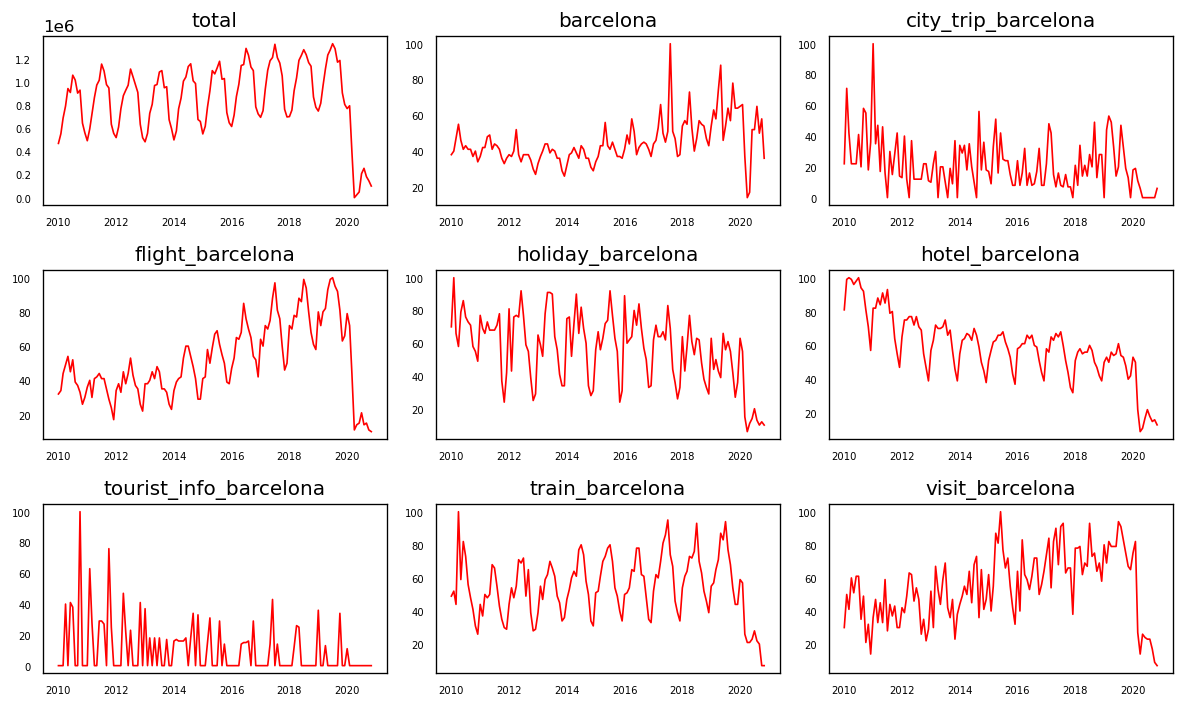

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = df[df.columns[i]]
 ax.plot(data, color="red", linewidth=1)
 ax.set_title(df.columns[i])
 ax.xaxis.set_ticks_position("none")
 ax.yaxis.set_ticks_position("none")
 ax.tick_params(labelsize=6)
plt.tight_layout()

# Vector Auto Regression

## Dimensionality reduction

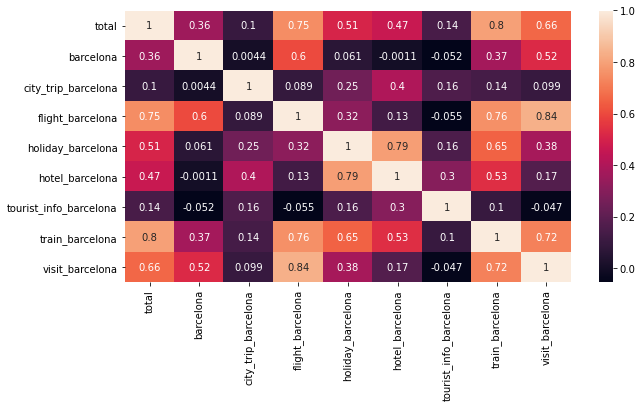

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.heatmap(df.corr(), annot=True)

We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

In [7]:
#Correlation with target variable
cor = df.corr()
cor_target = abs(cor["total"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

total                1.000000
flight_barcelona     0.749008
holiday_barcelona    0.506703
train_barcelona      0.797735
visit_barcelona      0.662877
Name: total, dtype: float64

In [172]:
#Creating df with selected features
X_red = df[["total", "flight_barcelona", "holiday_barcelona", "train_barcelona", "visit_barcelona"]].copy().sort_index()

In [244]:
features = {"flight_barcelona", "holiday_barcelona", "train_barcelona", "visit_barcelona"}
#Train test split with 70% on training set (most recent dates)
nobs = int(X_red.shape[0]*0.6)
train, test = X_red[:nobs], X_red[nobs:]

train_X  = train.loc[:,train.columns.get_level_values(0).isin(features)]
train_y = train.loc[:,train.columns.get_level_values(0).isin({"total"})]

test_X = test.loc[:,test.columns.get_level_values(0).isin(features)]
test_y = train.loc[:,train.columns.get_level_values(0).isin({"total"})]

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

### Dealing with seasonality: Augmented Dickey-Fuller Test

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [250]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADF to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    p_value = round(r[1], 4)
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')


    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        print(" ")

In [251]:
adfuller_test(train["total"], name="total_visitors")
adfuller_test(train["flight_barcelona"], name="flight_barcelona")
adfuller_test(train["holiday_barcelona"], name="holiday_barcelona")
adfuller_test(train["train_barcelona"], name="train_barcelona")
adfuller_test(train["visit_barcelona"], name="visit_barcelona")

    Augmented Dickey-Fuller Test on "total_visitors" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.9878. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 
    Augmented Dickey-Fuller Test on "flight_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.9989. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 
    Augmented Dickey-Fuller Test on "holiday_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.1727. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 
    Augmented Dickey-Fuller Test on "train_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Dat

The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.

In [252]:
df_differenced = train.diff().dropna()

In [253]:
adfuller_test(df_differenced["total"], name="total_visitors")
adfuller_test(df_differenced["flight_barcelona"], name="flight_barcelona")
adfuller_test(df_differenced["holiday_barcelona"], name="holiday_barcelona")
adfuller_test(df_differenced["train_barcelona"], name="train_barcelona")
adfuller_test(df_differenced["visit_barcelona"], name="visit_barcelona")

    Augmented Dickey-Fuller Test on "total_visitors" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.1243. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 
    Augmented Dickey-Fuller Test on "flight_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.3102. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 
    Augmented Dickey-Fuller Test on "holiday_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "train_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [254]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [255]:
adfuller_test(df_differenced["total"], name="total_visitors")
adfuller_test(df_differenced["flight_barcelona"], name="flight_barcelona")
adfuller_test(df_differenced["holiday_barcelona"], name="holiday_barcelona")
adfuller_test(df_differenced["train_barcelona"], name="train_barcelona")
adfuller_test(df_differenced["visit_barcelona"], name="visit_barcelona")

    Augmented Dickey-Fuller Test on "total_visitors" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "flight_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "holiday_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "train_barcelona" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0.

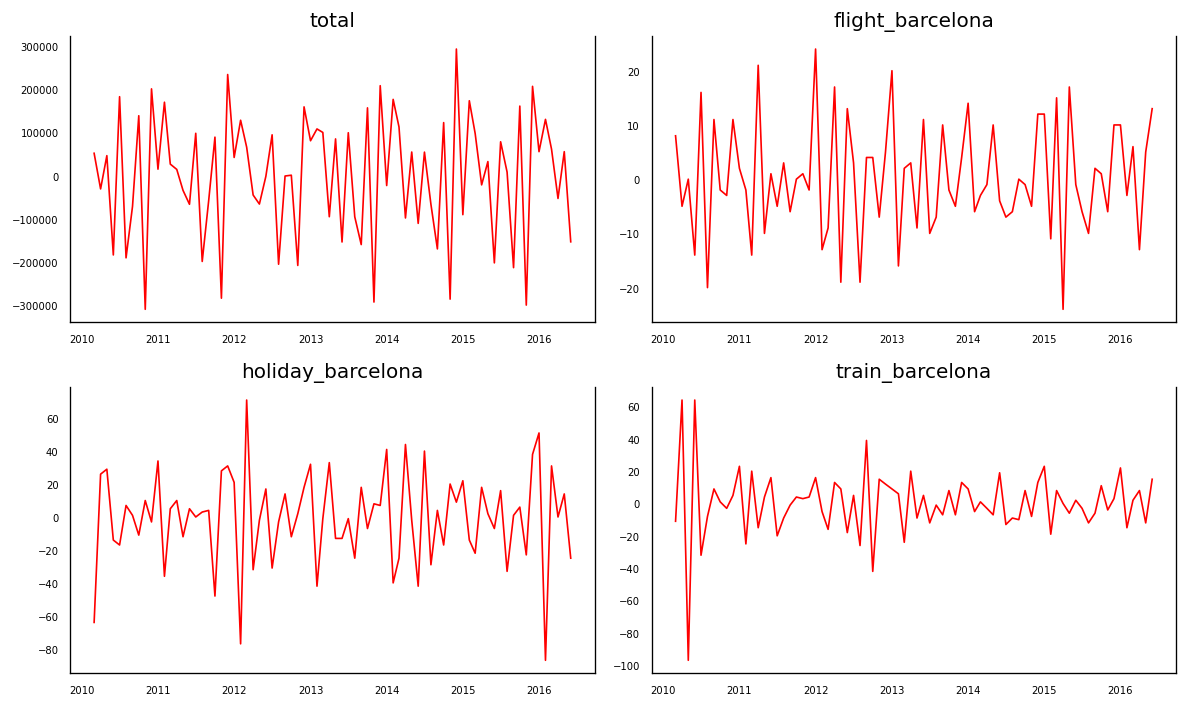

In [256]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = df_differenced[df_differenced.columns[i]]
    ax.plot(d, color='red', linewidth=1)
# Decorations
    ax.set_title(df_differenced.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

In [258]:
model = VAR(df_differenced)

model_fitted = model.fit()
model_fitted.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jan, 2021
Time:                     15:04:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    46.4929
Nobs:                     75.0000    HQIC:                   45.9360
Log likelihood:          -2210.82    FPE:                6.16263e+19
AIC:                      45.5659    Det(Omega_mle):     4.19418e+19
--------------------------------------------------------------------
Results for equation total
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    -1165.276035     13792.007812           -0.084           0.933
L1.total                    -0.475719         0.100302           -4.743           0.000
L1.flight_barcelona       1534.2

In [276]:
y_test.shape

(40,)

In [278]:
model = VAR(train_X, freq="MS")
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(X_test, steps=40)
df_forecast = pd.DataFrame(prediction, index=test.index, columns=df_differenced.columns + '_2d')
df_forecast.head(3)

KeyError: -1

The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data. (2 times)

In [260]:
def invert_transformation(train, forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [261]:
df_results = invert_transformation(test, df_forecast, second_diff=True)

In [262]:
forecast = df_results[["total_forecast", "flight_barcelona_forecast", "holiday_barcelona_forecast", 
            "train_barcelona_forecast", "visit_barcelona_forecast"]].copy()
forecast.head()

,total_forecast,flight_barcelona_forecast,holiday_barcelona_forecast,train_barcelona_forecast,visit_barcelona_forecast
period,,,,,
2016-07-01,1.301117e+06,88.540951,77.172589,89.181039,91.062464
2016-08-01,3.773570e+06,240.353534,212.354398,251.687194,253.965028
2016-09-01,7.499828e+06,458.847100,412.999500,489.195550,488.999088
2016-10-01,1.242436e+07,737.513459,675.657868,795.779332,789.385350
2016-11-01,1.847063e+07,1070.531492,997.599533,1165.862533,1149.413818


In [264]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test["total"], forecast["total_forecast"]))

628159058.2396138

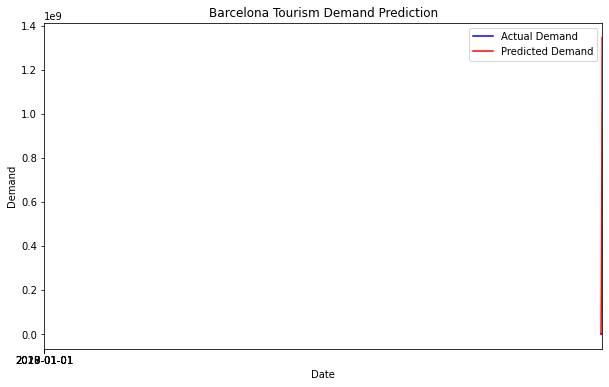

In [217]:
plt.figure(figsize=(10,6))
plt.plot(test["total"], color='blue', label='Actual Demand')
plt.plot(forecast["total_forecast"], color='red', label='Predicted Demand')
plt.title('Barcelona Tourism Demand Prediction')
plt.xlabel('Date')
plt.xticks(ticks=np.arange(48, step=12), labels=labels)
plt.ylabel('Demand')
plt.legend()
plt.show()

# LSTM

In [139]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled)

In [140]:
# split into train and test sets
values = scaled.values
n_train_years = 7 * 12
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
train_X, train_y = train[:,1:], train[:,0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(84, 1, 8) (84,) (47, 1, 8) (47,)


In [141]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(2, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=80, 
                    verbose=0, shuffle=False)

In [142]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()
# Changing the array to 1d

# calculate RMSE
r2 = r2_score(test_y, yhat)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test R2 score: %.3f' % r2)
print('Test RMSE score: %.3f' % rmse)

Test R2 score: -0.650
Test RMSE score: 0.196


In [143]:
labels = ("2017-01-01", "2018-01-01", "2019-01-01", "2020-01-01", "2021-01-01")

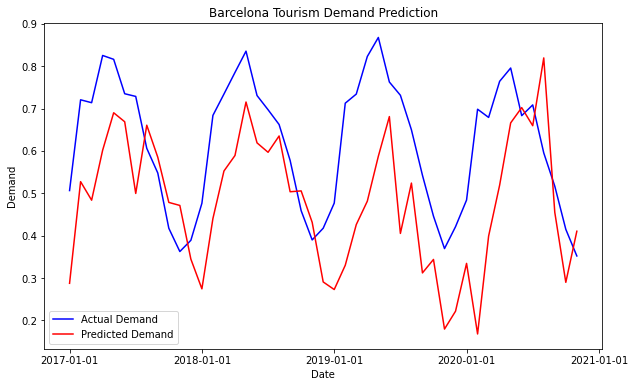

In [144]:
plt.figure(figsize=(10,6))
plt.plot(test_y, color='blue', label='Actual Demand')
plt.plot(yhat, color='red', label='Predicted Demand')
plt.title('Barcelona Tourism Demand Prediction')
plt.xlabel('Date')
plt.xticks(ticks=np.arange(60, step=12), labels=labels)
plt.ylabel('Demand')
plt.legend()
plt.show()